In [133]:
# Monte-Carlo post-processing - mcvis.ipynb
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

FILE_NO = 4

# 1) Scalars (CSV) -> df   [leave this as-is]
CSV_PATH = f"mc_data/mc_output{FILE_NO}.csv"
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df):,} rows from {CSV_PATH}")

# 2) Per-scene grids (Parquet) -> grid_df
PARQUET = f"mc_data/grids_mc{FILE_NO}.parquet"
grid_df = pd.read_parquet(PARQUET)
print(f"Loaded {len(grid_df):,} rows from {PARQUET}")

# Optional sanity check: they should be the same length and aligned by row
assert len(df) == len(grid_df), "CSV and Parquet row counts differ; plotting may misalign."


Loaded 10,000 rows from mc_data/mc_output4.csv
Loaded 10,000 rows from mc_data/grids_mc4.parquet


## ========== **Visualize the shield geometry** ==========

### Flat Shield

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from geometry import Shield              

#  FLAT (disk) shield
def flat_vertices(radius: float,
                  n_facets: int = 40,
                  flip_z: bool = False):
    """
    verts, faces = flat_vertices(radius, n_facets)

    • radius     disk radius (m)
    • n_facets   how many straight edges to approximate the circle
    • flip_z     True -> plate lies at Z = -theta   (convex faces +Z),
                  False (default) leaves it at Z = theta
    """
    phi = np.linspace(0, 2*np.pi, n_facets, endpoint=False)
    rim = np.c_[radius*np.cos(phi), radius*np.sin(phi), np.zeros(n_facets)]
    center = np.array([[0.0, 0.0, 0.0]])
    verts = np.vstack([center, rim])                # theta = centre
    faces = [[0, i+1, ((i+1)%n_facets)+1] for i in range(n_facets)]

    if flip_z:
        verts[:, 2] -= 1e-12   # tiny negative value so it’s “below” origin

    return verts, faces


def plot_flat(shield: Shield, flip_z: bool = False):
    V, F = flat_vertices(shield.primary_dim, flip_z=flip_z)
    fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot(111, projection='3d')
    for f in F:
        loop = f + [f[0]]; ax.plot(*(V[loop].T))
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'Flat disk – r = {shield.primary_dim:.2f} m')
    plt.tight_layout(); plt.show()
    
def plot_shield(shield: Shield, flip_z: bool = True):
    fig = plt.figure(figsize=(6, 6))
    ax  = fig.add_subplot(111, projection='3d')

    if shield.profile == "cupola":
        V, F = cupola_vertices(shield.primary_dim,
                               include_base=shield.include_base,
                               include_top =shield.include_top,
                               flip_z=flip_z)
    else:
        raise ValueError("Only profile='cupola' is implemented here.")

    for f in F:
        loop = f + [f[0]]
        ax.plot(*(V[loop].T), linewidth=1)

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'{shield.profile.capitalize()} – edge = {shield.primary_dim:.2f} m')
    plt.tight_layout()
    plt.show()



### Pyramid Shield

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from geometry import Shield

#  PYRAMID shield  
def pyramid_vertices(a: float,
                     include_base: bool = True,
                     flip_z: bool       = False):
    """
    verts, faces = pyramid_vertices(a, ...)

    • a              edge length (metres)
    • include_base   add the square base (absorbing in MC, but nice for plots)
    • flip_z         True -> base down (convex faces +Z); default base up
    """
    h = a / np.sqrt(2)                          # height for equilateral faces
    # base square (CCW if viewed from +Z)
    Vb = np.array([[+a/2, +a/2, 0.0],
                   [-a/2, +a/2, 0.0],
                   [-a/2, -a/2, 0.0],
                   [+a/2, -a/2, 0.0]])
    Vtop = np.array([[0.0, 0.0, h]])
    verts = np.vstack([Vtop, Vb])               # theta = apex

    faces = [[0, i+1, (i+1)%4 +1] for i in range(4)]   # 4 triangles
    if include_base:
        faces.append([1,2,3,4])                 # square base

    if flip_z:
        verts[:, 2] *= -1

    return verts, faces


def plot_pyramid(shield: Shield, flip_z: bool = True):
    V, F = pyramid_vertices(shield.primary_dim, flip_z=flip_z)
    fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot(111, projection='3d')
    for f in F:
        loop = f + [f[0]]; ax.plot(*(V[loop].T))
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'Square pyramid - a = {shield.primary_dim:.2f} m')
    plt.tight_layout(); plt.show()
    
def cupola_vertices(a: float,
                    include_base: bool = True,
                    include_top:  bool = False,
                    flip_z: bool       = False):
    """
    verts, faces = cupola_vertices(a, ...)

    • a            edge length (metres)
    • include_base add the decagon fan
    • include_top  add the tiny pentagon roof
    • flip_z       True  -> base faces -Z  (diagram view)
    """
    # Key radii / heights 
    r_p = a / (2*np.sin(np.pi/5))          # pentagon circ. radius
    r_d = a / (2*np.sin(np.pi/10))         # decagon circ. radius
    z_p, z_d = 0.0, -a                     # squares are one edge tall

    # Vertex rings
    phi_p = np.linspace(np.pi/2, 2*np.pi + np.pi/2, 5, endpoint=False)
    Vp = np.c_[r_p*np.cos(phi_p),  r_p*np.sin(phi_p),  np.full(5, z_p)]

    # two decagon verts per square: –18 degrres & +18 degrees around each pentagon vert
    phi_d = phi_p[:, None] + np.deg2rad([-18, +18])
    Vd = np.c_[r_d*np.cos(phi_d.ravel()),
              r_d*np.sin(phi_d.ravel()),
              np.full(10, z_d)]

    verts = np.vstack([Vp, Vd])            # 15 vertices total

    # Faces 
    squares   = [[i,
                  (i+1) % 5,
                  5+(2*i+1) % 10,
                  5+2*i]                   # bottom uses decagon verts
                 for i in range(5)]

    triangles = [[i,
                  5+2*i,
                  5+(2*i+1) % 10]            # triangle between squares
                 for i in range(5)]

    faces = squares + triangles

    if include_base:                       # 5-triangle decagon fan
        faces += [[5+i,
                   5+(i+1) % 10,
                   5+(i+2)%10]
                  for i in range(0,10,2)]
    if include_top:                        # tiny roof (optional)
        faces += [[0,1,2], [0,2,3], [0,3,4]]

    if flip_z:
        verts[:, 2] *= -1

    return verts, faces


### Spherical Cap Shield

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from geometry import Shield

def cap_vertices(a: float,
                 curvature: float,
                 n_theta: int = 15,
                 n_phi: int   = 32,
                 flip_z: bool = False):
    """
    verts, faces = cap_vertices(edge_radius, curvature, ...)

    • a          rim radius (m)   ( = shield.primary_dim in your code)
    • curvature  1 / sphere_radius  (1/m)
    • n_theta    # of latitude bands
    • n_phi      # of longitude splits
    • flip_z     True -> bowl faces +Z (convex up); default convex down
    """
    R = 1.0 / curvature
    theta_max = np.arcsin(a / R)               # half-angle of cap
    theta = np.linspace(0, theta_max, n_theta) # theta = pole, max = rim
    phi = np.linspace(0, 2*np.pi, n_phi, endpoint=False)

    verts = []
    for t in theta:
        ring_r = R * np.sin(t)
        z      = R * (np.cos(t) - np.cos(theta_max))    # z = theta at rim
        verts.extend(np.c_[ring_r*np.cos(phi), ring_r*np.sin(phi), np.full(n_phi, z)])
    verts = np.array(verts)

    # build quad strips (as triangle pairs)
    n_rings = len(theta)
    faces = []
    for r in range(n_rings-1):
        for p in range(n_phi):
            p_next = (p+1) % n_phi
            v00 = r*n_phi + p
            v01 = r*n_phi + p_next
            v10 = (r+1)*n_phi + p
            v11 = (r+1)*n_phi + p_next
            faces += [[v00, v10, v11], [v00, v11, v01]]

    if flip_z:
        verts[:, 2] *= -1

    return verts, faces


def plot_cap(shield: Shield, flip_z: bool = False):
    V, F = cap_vertices(shield.primary_dim,
                        curvature=shield.shape_param,
                        flip_z=flip_z)
    fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot(111, projection='3d')
    for f in F:
        loop = f + [f[0]]; ax.plot(*(V[loop].T))
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'Spherical cap – r = {shield.primary_dim:.2f} m')
    plt.tight_layout(); plt.show()


 flat


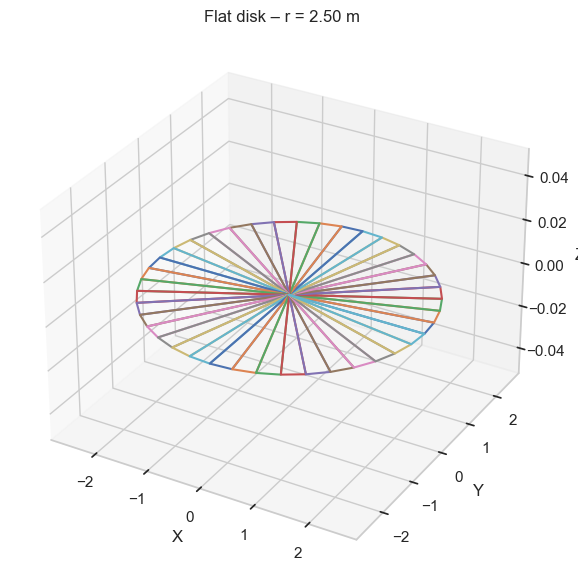

 pyramid


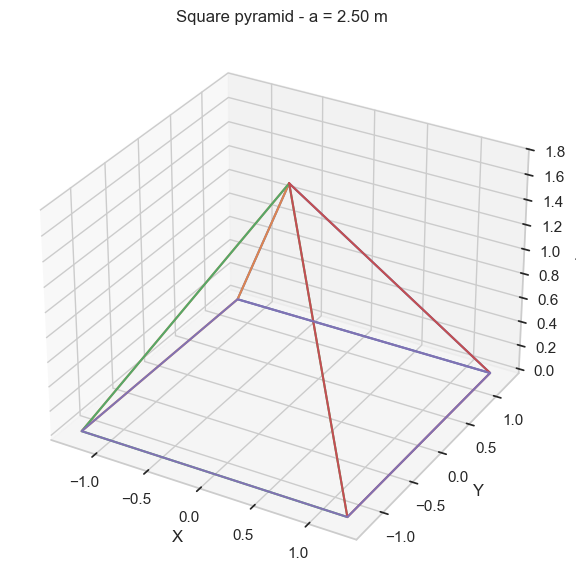

 cap


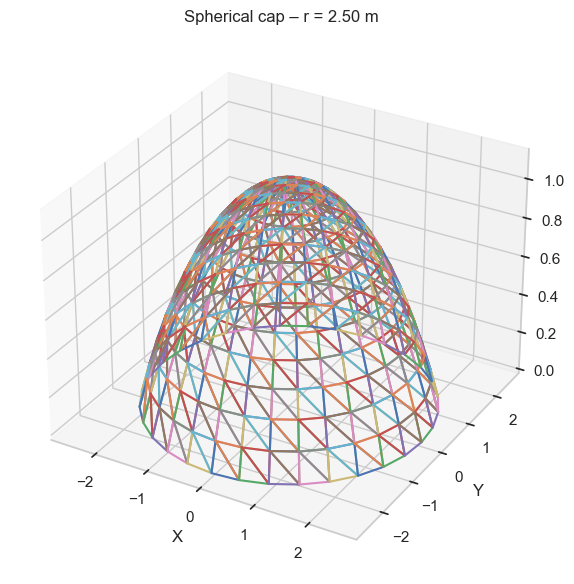

 cupola


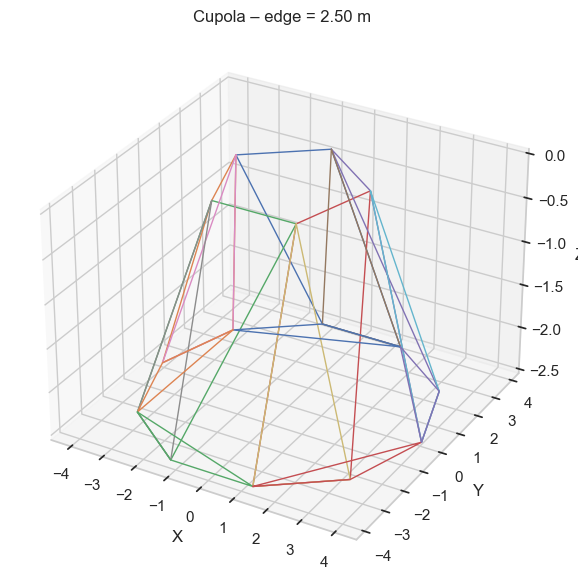

In [137]:
# make one shield per shape so each helper sees the profile it expects
demo_shields = {
    "flat":   Shield(primary_dim=2.5, shape_param=0.0,  thickness=0.003,
                     coating_type="specular", profile="flat"),
    "pyramid":Shield(primary_dim=2.5, shape_param=0.0,  thickness=0.003,
                     coating_type="specular", profile="pyramid"),
    "cap":    Shield(primary_dim=2.5, shape_param=0.3,  thickness=0.003,
                     coating_type="specular", profile="cap"),   # R is about 3.33 m
    "cupola": Shield(primary_dim=2.5, shape_param=1.0,  thickness=0.003,
                     coating_type="specular", profile="cupola"),
}

profiles = {
    "flat":   plot_flat,
    "pyramid":plot_pyramid,
    "cap":    plot_cap,
    "cupola": plot_shield,
}

for name, plotter in profiles.items():
    print(f" {name}")
    plotter(demo_shields[name], flip_z=False)


,primary_dim,shape_param,mass,mean_deflection_deg,hit_ratio,wake_intrusion_ratio,wafer_flux_m2s
count,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,1.000000e+04
mean,3.2526,1.0575,451.2099,64.9471,0.0004,0.3670,1.053845e+18
std,1.3875,0.8381,699.0158,27.9353,0.0009,0.2279,2.051980e+18
min,1.0002,0.0000,2.8888,12.6026,0.0000,0.0549,0.000000e+00
5%,1.2035,0.0000,5.1621,12.8240,0.0000,0.1094,0.000000e+00
25%,2.0862,0.0000,19.1749,45.9372,0.0000,0.1272,0.000000e+00
50%,3.1490,1.0000,191.0544,61.4832,0.0000,0.3080,0.000000e+00
75%,4.3439,1.5015,493.7974,89.5831,0.0000,0.4393,0.000000e+00
95%,5.6652,2.7082,2174.5560,101.6112,0.0026,0.8384,5.588749e+18
max,5.9991,2.9988,4185.6128,126.6820,0.0064,0.9423,1.143470e+19



========= Hit ratio statistics by shield profile =========

          count          mean       std  min     25%     50%     75%     max
profile                                                                     
cap      2503.0  0.000000e+00  0.000000  0.0  0.0000  0.0000  0.0000  0.0000
cupola   2549.0  1.511142e-03  0.001204  0.0  0.0006  0.0011  0.0022  0.0064
flat     2513.0  0.000000e+00  0.000000  0.0  0.0000  0.0000  0.0000  0.0000
pyramid  2435.0  4.928131e-07  0.000008  0.0  0.0000  0.0000  0.0000  0.0002


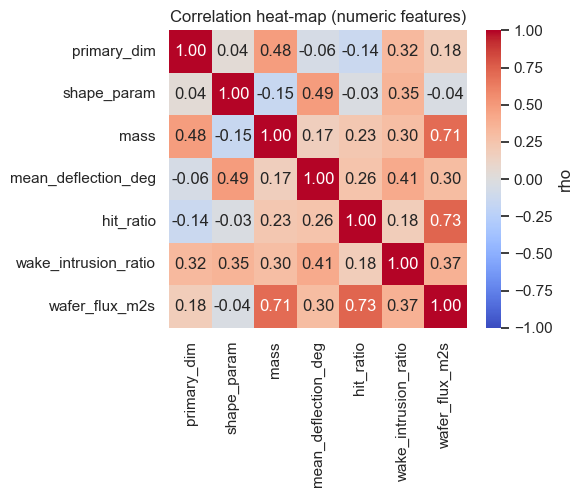

In [138]:
# --- Descriptive statistics & correlation heat‑map --------------------------
numeric_cols = ["primary_dim", "shape_param", "mass",
                "mean_deflection_deg", "hit_ratio", "wake_intrusion_ratio", "wafer_flux_m2s"]

display(df[numeric_cols].describe(percentiles=[.05,.25,.5,.75,.95]).round(4))
print(f"\n========= Hit ratio statistics by shield profile =========\n")
print(df.groupby("profile")["hit_ratio"].describe())

corr = df[numeric_cols].corr(method="pearson")

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm",
            square=True, cbar_kws={"label":"rho"})
plt.title("Correlation heat-map (numeric features)")
plt.tight_layout()
plt.show()


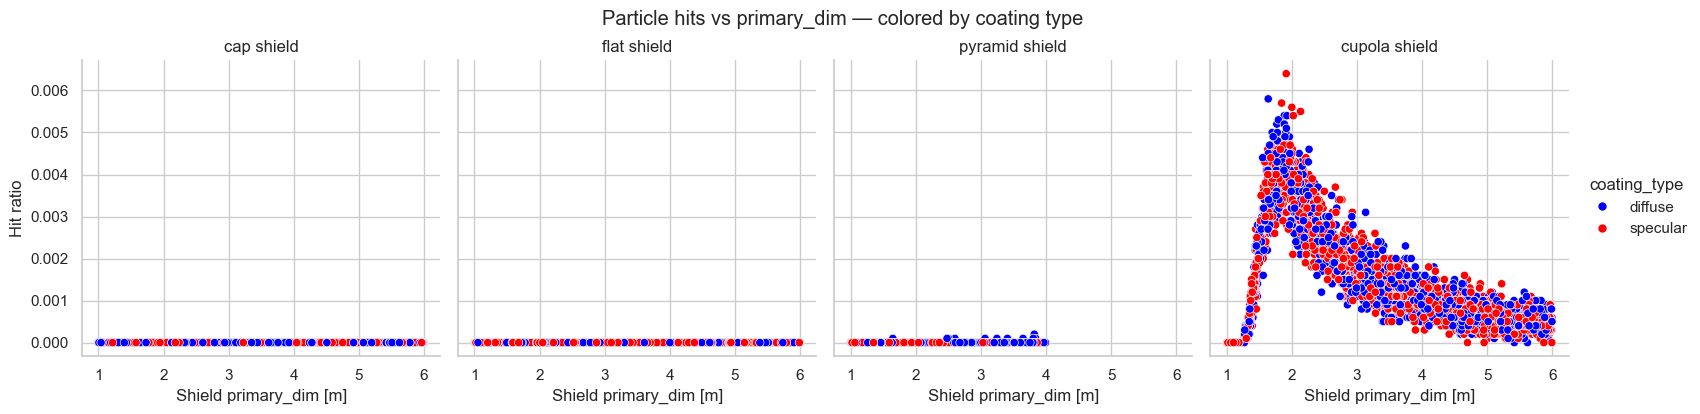

In [139]:
# --- Scatterplots: hit_ratio -----------------------------------------------
custom_palette = {
    "diffuse": "blue",
    "specular": "red"
}

g = sns.relplot(
    data=df, x="primary_dim", y="hit_ratio",
    col="profile", hue="coating_type", palette=custom_palette,
    col_order=["cap", "flat", "pyramid", "cupola"],
    height=4, aspect=1
)

g.set_axis_labels("Shield primary_dim [m]", "Hit ratio")
g.set_titles(col_template="{col_name} shield")
g.fig.suptitle("Particle hits vs primary_dim — colored by coating type", y=1.03)
plt.show()


Detected grid: 50 x 50
cap     | scenes=2503 | total wafer hits=0
flat    | scenes=2513 | total wafer hits=0
pyramid | scenes=2435 | total wafer hits=12
cupola  | scenes=2549 | total wafer hits=38519


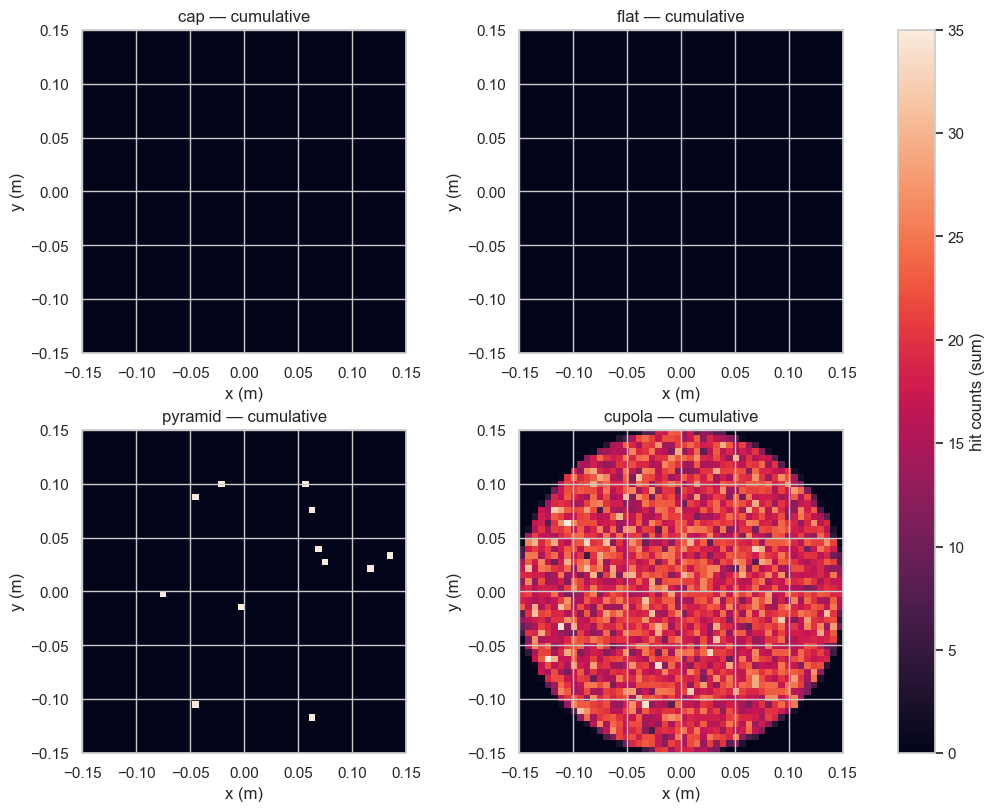

In [140]:
# --- Heatmap of cummulative hits:
# Discover grid columns and size from grid_df
grid_cols = sorted([c for c in grid_df.columns if c.startswith("g")])
N = int(np.sqrt(len(grid_cols)))
print(f"Detected grid: {N} x {N}")

def plot_heatmap(G, R=0.15, title=""):
    plt.figure(figsize=(5,4))
    plt.imshow(G, origin="lower", extent=[-R, R, -R, R], vmin=0)
    plt.xlabel("x (m)"); plt.ylabel("y (m)")
    plt.title(title); plt.colorbar(label="hit counts")
    plt.tight_layout(); plt.show()

# --- cumulative wafer-hit heatmaps for each profile (sum over scenes) ---
# Totals per profile
profiles = ["cap","flat","pyramid","cupola"]
for p in profiles:
    sub = grid_df.loc[grid_df["profile"]==p, grid_cols]
    total = sub.to_numpy(dtype=np.float64).sum()
    print(f"{p:7s} | scenes={len(sub):4d} | total wafer hits={int(total)}")

# Optional: plot with per-panel scaling (or log scale) to reveal tiny counts
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2,2,figsize=(10,8), constrained_layout=True)
R = 0.15
for ax, p in zip(axes.flat, profiles):
    sub = grid_df.loc[grid_df["profile"]==p, grid_cols]
    G = sub.to_numpy(dtype=np.float64).sum(0).reshape(N,N)
    if G.max() > 0:
        # choose ONE of these:
        im = ax.imshow(G, origin="lower", extent=[-R,R,-R,R], vmin=0, vmax=G.max())  # per-panel linear
        # im = ax.imshow(G, origin="lower", extent=[-R,R,-R,R], norm=LogNorm(vmin=1, vmax=G.max()))  # log scale
    else:
        im = ax.imshow(G, origin="lower", extent=[-R,R,-R,R], vmin=0, vmax=1)
    ax.set_title(f"{p} — cumulative")
    ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
fig.colorbar(im, ax=axes.ravel().tolist(), label="hit counts (sum)")
plt.show()

C:\Users\Risha\AppData\Local\Temp\ipykernel_26640\4142286010.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pyramid_df = df[df['profile'] == 'pyramid'][df['coating_type'] == 'specular']


,primary_dim,shape_param,mass,mean_deflection_deg,hit_ratio,wake_intrusion_ratio,wafer_flux_m2s
count,1193.0000,1193.0000,1193.0000,1193.0000,1193.0,1193.0000,1193.0
mean,2.5237,0.9976,248.6011,92.1997,0.0,0.1152,0.0
std,0.8663,0.2901,168.8005,17.2422,0.0,0.0064,0.0
min,1.0005,0.5010,23.3586,66.7937,0.0,0.1009,0.0
5%,1.1317,0.5532,43.2129,68.6243,0.0,0.1064,0.0
25%,1.7920,0.7426,106.4504,76.8674,0.0,0.1109,0.0
50%,2.5298,0.9914,214.4476,90.3020,0.0,0.1140,0.0
75%,3.2722,1.2498,358.7356,106.5343,0.0,0.1187,0.0
95%,3.8555,1.4526,567.0611,121.9410,0.0,0.1275,0.0
max,3.9966,1.4988,865.0043,126.6820,0.0,0.1419,0.0



========= Hit ratio statistics by shield profile =========

          count          mean       std  min     25%     50%     75%     max
profile                                                                     
cap      2503.0  0.000000e+00  0.000000  0.0  0.0000  0.0000  0.0000  0.0000
cupola   2549.0  1.511142e-03  0.001204  0.0  0.0006  0.0011  0.0022  0.0064
flat     2513.0  0.000000e+00  0.000000  0.0  0.0000  0.0000  0.0000  0.0000
pyramid  2435.0  4.928131e-07  0.000008  0.0  0.0000  0.0000  0.0000  0.0002


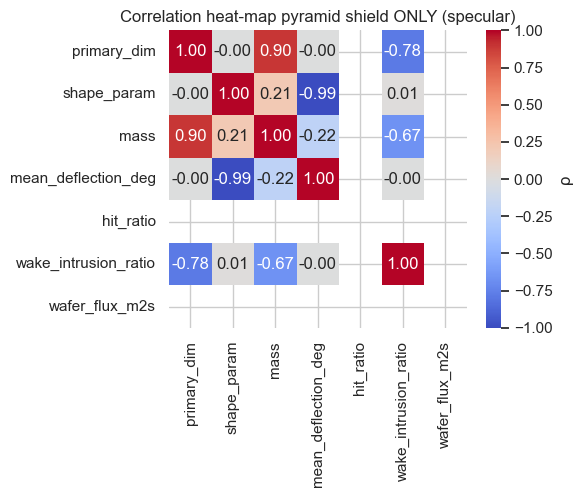

In [141]:
# Correlation matrix for only the pyramid

pyramid_df = df[df['profile'] == 'pyramid'][df['coating_type'] == 'specular']
numeric_cols = ["primary_dim", "shape_param", "mass",
                "mean_deflection_deg", "hit_ratio", "wake_intrusion_ratio", "wafer_flux_m2s"]


display(pyramid_df[numeric_cols].describe(percentiles=[.05,.25,.5,.75,.95]).round(4))
print(f"\n========= Hit ratio statistics by shield profile =========\n")
print(df.groupby("profile")["hit_ratio"].describe())

corr = pyramid_df[numeric_cols].corr(method="pearson")

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm",
            square=True, cbar_kws={"label":"ρ"})
plt.title("Correlation heat-map pyramid shield ONLY (specular)")
plt.tight_layout()
plt.show()

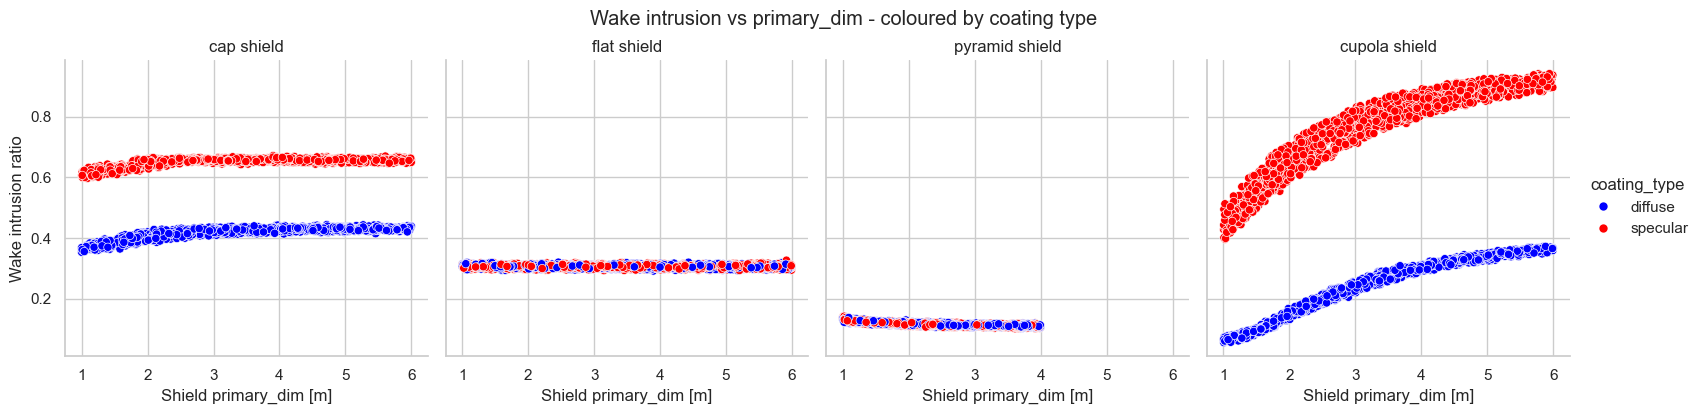

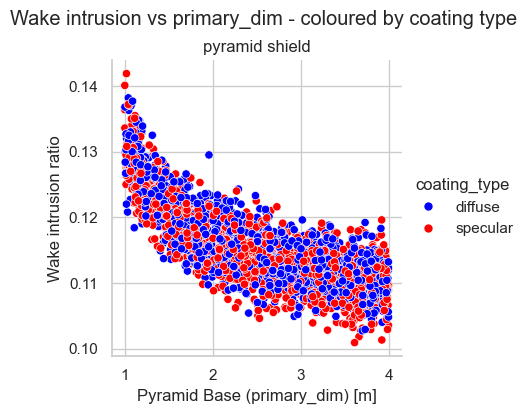

In [142]:
# --- Scatterplots: wake_intrusion_ratio -------------------------------------
custom_palette = {
    "specular": "red", 
    "diffuse": "blue",   
}

# Plot with flipped colors
g = sns.relplot(
    data=df, x="primary_dim", y="wake_intrusion_ratio",
    col="profile", hue="coating_type", palette=custom_palette,
    col_order=["cap", "flat", "pyramid", "cupola"],
    height=4, aspect=1
)
g.set_axis_labels("Shield primary_dim [m]", "Wake intrusion ratio")
g.set_titles(col_template="{col_name} shield")
g.fig.suptitle("Wake intrusion vs primary_dim - coloured by coating type", y=1.03)
plt.show()

# wake intrustion ratio for only the pyramid shield 
pyramid_scatter = sns.relplot(
    data=df[df['profile'] == 'pyramid'], x="primary_dim", y="wake_intrusion_ratio",
    col="profile", hue="coating_type", palette=custom_palette,
    col_order=["pyramid"],
    height=4, aspect=1
)
pyramid_scatter.set_axis_labels("Pyramid Base (primary_dim) [m]", "Wake intrusion ratio")
pyramid_scatter.set_titles(col_template="{col_name} shield")
pyramid_scatter.fig.suptitle("Wake intrusion vs primary_dim - coloured by coating type", y=1.03)
plt.show()


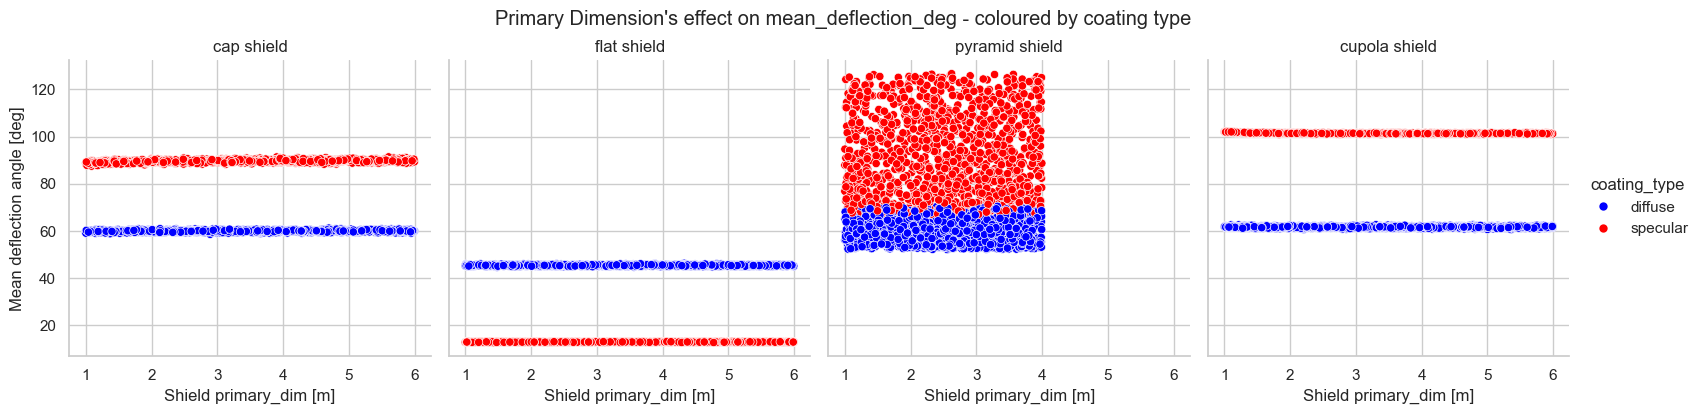

In [143]:
# --- Scatterplots: hit_ratio -----------------------------------------------
custom_palette = {
    "specular": "red",  
    "diffuse": "blue",   
}

# Plot: mean deflection vs primary_dim
g = sns.relplot(
    data=df, x="primary_dim", y="mean_deflection_deg",
    col="profile", hue="coating_type", palette=custom_palette,
    col_order=["cap", "flat", "pyramid", "cupola"],
    height=4, aspect=1
)

g.set_axis_labels("Shield primary_dim [m]", "Mean deflection angle [deg]")
g.set_titles(col_template="{col_name} shield")
g.fig.suptitle("Primary Dimension's effect on mean_deflection_deg - coloured by coating type", y=1.03)
plt.show()

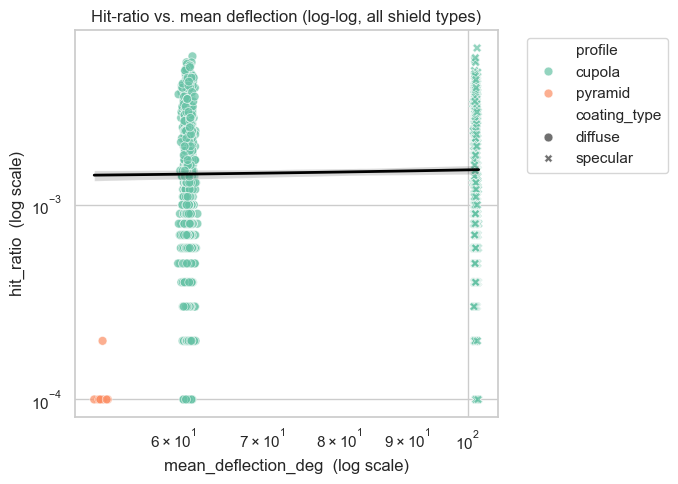

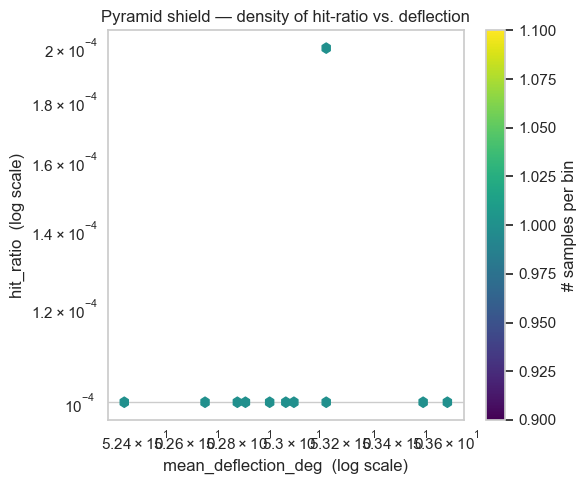

In [144]:
# ------------------------------------------------------------------
#  A. Global log–log scatter (all shields together)
# ------------------------------------------------------------------
df_plot = df[(df["mean_deflection_deg"] > 0) & (df["hit_ratio"] > 0)]

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_plot,
                x="mean_deflection_deg", y="hit_ratio",
                hue="profile", style="coating_type",
                palette="Set2", s=40, alpha=0.7)

# add one robust global trend line (black)
sns.regplot(data=df_plot, x="mean_deflection_deg", y="hit_ratio",
            scatter=False, robust=True, color="black",
            line_kws={"lw":2, "label":"overall trend"})

plt.xscale("log")
plt.yscale("log")
plt.xlabel("mean_deflection_deg  (log scale)")
plt.ylabel("hit_ratio  (log scale)")
plt.title("Hit-ratio vs. mean deflection (log-log, all shield types)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


# ------------------------------------------------------------------
#  B.  Pyramid shield only – hex-bin density plot
# ------------------------------------------------------------------
pyr = df[(df["profile"]=="pyramid") & (df["mean_deflection_deg"] > 0)]

pyr_nz = pyr[(pyr["mean_deflection_deg"] > 0) & (pyr["hit_ratio"] > 0)]

plt.figure(figsize=(6, 5))
hb = plt.hexbin(
        pyr_nz["mean_deflection_deg"],
        pyr_nz["hit_ratio"],
        gridsize=40, mincnt=1, cmap="viridis",
        xscale="log", yscale="log"
)
plt.colorbar(hb, label="# samples per bin")

plt.xlabel("mean_deflection_deg  (log scale)")
plt.ylabel("hit_ratio  (log scale)")
plt.title("Pyramid shield — density of hit-ratio vs. deflection")
plt.tight_layout()
plt.show()

In [145]:
# --- Rank designs: lowest contamination, lowest intrusion, highest deflection
ranking_cols = ["hit_ratio","wake_intrusion_ratio","mean_deflection_deg", "wafer_flux_m2s"]
ranked = df.sort_values(ranking_cols, ascending=[True, True, False, True])

overall_best = ranked.iloc[0]
print("Overall best design (row index {}):".format(overall_best.name))
display(overall_best.to_frame().T)

by_profile = ranked.groupby('profile').first()
print("\nBest per profile:")
display(by_profile)


Overall best design (row index 904):


,profile,primary_dim,shape_param,thickness,coating_type,z_offset,xy_offset_x,xy_offset_y,mass,mean_deflection_deg,hit_ratio,wafer_flux_m2s,wake_intrusion_ratio,wake_type
904,cupola,1.005375,1.0,0.002378,diffuse,-1.470614,0.025293,-0.049901,96.452144,61.655434,0.0,0.0,0.0549,WakeCone



Best per profile:


,primary_dim,shape_param,thickness,coating_type,z_offset,xy_offset_x,xy_offset_y,mass,mean_deflection_deg,hit_ratio,wafer_flux_m2s,wake_intrusion_ratio,wake_type
profile,,,,,,,,,,,,,
cap,1.001350,1.502108,0.001951,diffuse,-1.365649,-0.047858,-0.006673,14.666043,59.500687,0.0,0.0,0.3529,WakeCone
cupola,1.005375,1.000000,0.002378,diffuse,-1.470614,0.025293,-0.049901,96.452144,61.655434,0.0,0.0,0.0549,WakeCone
flat,3.898868,0.000000,0.001629,diffuse,-1.394408,0.035853,-0.040617,210.045126,45.313519,0.0,0.0,0.2912,WakeCone
pyramid,3.609055,1.330337,0.002702,specular,-1.225026,0.036688,0.033831,632.473901,73.157226,0.0,0.0,0.1009,PyramidWake
